# Template for the usage of the project

Small example on basis of the first task to show the usage and test/debug the project.

## Environment Setup



In [3]:
import os
from pathlib import Path as P

import numpy as np

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import ruamel.yaml
yaml = ruamel.yaml.YAML()

import optuna

# Import project
import experiments
import models
import src
import utils


###--- Jupyter Environment Parameter ---###
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CONFIG_PATH = None

EXPERIMENT_NAME = 'template'
RUN_NAME = 'test_01'

WRITE_LOGS = False # Log data that is produced withing the notebook

# Set required environment variables
os.environ['EXP_DIRECTORY'] = str((P(os.getcwd())) / "experiments") # Assumes notebook is run from the base directory
os.environ['ACTIVATE_EXP'] = EXPERIMENT_NAME
os.environ['ACTIVE_RUN'] = RUN_NAME


## Hyperparameters

In [4]:
###--- Model Configuration ---###
MODEL_CONFIG = {
                        'run_name' : 'test',
                        'model' : 'mlp',
                        'num_epochs' : 10,
                        'num_iterations': 0,       # 0 indicates that in each epoch the complete dataset is traversed. This value should be overwritter in code.
                        'dataset': {
                                'name': 'svhn',
                                'train_size': 73257,
                                'val_size': 6000,
                                'test_size': 26032,
                                'train_shuffle': True,
                                'eval_shuffle': False,
                                'drop_last': True
                        },
                        'batch_size' : 64,
                        'loss': {
                                'type': 'CrossEntropy'
                        },
                        'eval_batch_size': 32,
                        'eval_frequency' : 2,
                        'pre_processing': {
                                'flatten': True,
                                'flatten_only_img_sizes': True,
                                'rgb2gray': True,
                                'lbl_oneHot': True
                        },
                        'layers': [
                                {
                                'type': 'linear',
                                'dimension': 518,
                                'activation': 'relu'
                                },
                                {
                                'type': 'linear',
                                'dimension': 128,
                                'activation': 'relu'
                                },
                                {
                                'type': 'linear',
                                'dimension': 64,
                                'activation': 'relu'
                                },
                                {
                                'type': 'linear',
                                'dimension': 32,
                                'activation': 'relu'
                                },
                                {
                                'type': 'linear',
                                'dimension': 10,
                                'activation': 'softmax'
                                }

                        ],
                        'input_dim': 1024,
                        'output_dim': 10,
                        'optimizer': {
                                'type': 'Adam',
                                'learning_rate': 0.001,
                                'betas': [0.9, 0.99],
                                'eps': 0.00000001
                        },
                        'evaluation': {
                                'metrics': ['accuracy'],
                                'classes': [],   # Has to be defined prior to training from the dataset meta information.
                        },
                        'save_frequency': 2,
                        'random_seed': 42,
                        'verbosity_level': 1    
                        }

    
###--- Hyperparameter Optimization Configuration ---###
OPTIMIZATION_CONFIG = {}



### Data Loading ###

Load data and print example images.

In [5]:
if MODEL_CONFIG['dataset']['name'] == 'svhn':
    train_dataset, test_dataset = utils.load_svhn_dataset()
elif MODEL_CONFIG['dataset']['name'] == 'mnist':
    train_dataset, test_dataset = utils.load_mnist_dataset()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=MODEL_CONFIG['batch_size'], shuffle=MODEL_CONFIG['dataset']['train_shuffle'], drop_last=MODEL_CONFIG['dataset']['drop_last'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=MODEL_CONFIG['eval_batch_size'], shuffle=MODEL_CONFIG['dataset']['eval_shuffle'], drop_last=MODEL_CONFIG['dataset']['drop_last'])

print('\n')
print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

Using downloaded and verified file: ./data/svhn/train_32x32.mat
Using downloaded and verified file: ./data/svhn/test_32x32.mat


Train dataset size: 73257
Test dataset size: 26032


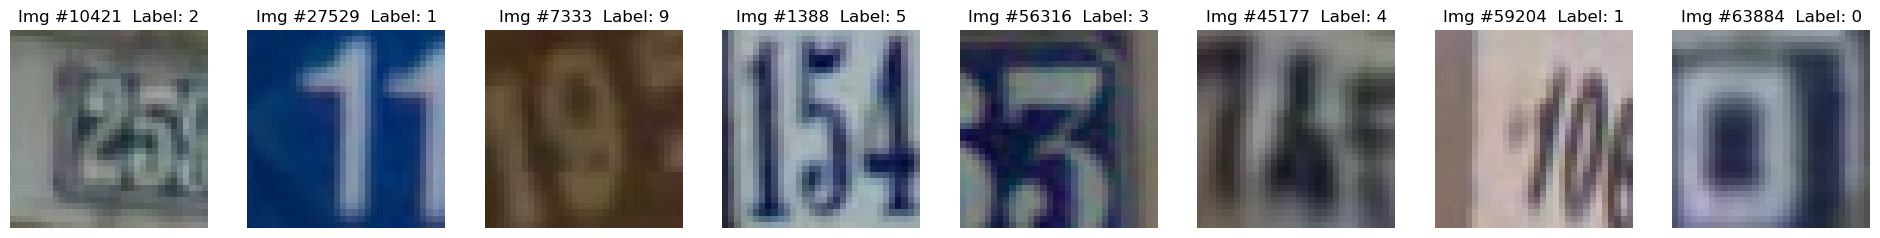

In [6]:
###--- Visualize Training Images ---###

NUM_IMG = 8

fig, ax = plt.subplots(1,NUM_IMG)
fig.set_size_inches(3 * NUM_IMG, 3)

ids = np.random.randint(low=0, high=len(train_dataset), size=NUM_IMG)

for i, n in enumerate(ids):
    img = train_dataset[n][0].permute(1,2,0)
    label = train_dataset[n][1]
    ax[i].imshow(img)
    ax[i].set_title(f"Img #{n}  Label: {label}")
    ax[i].axis("off")


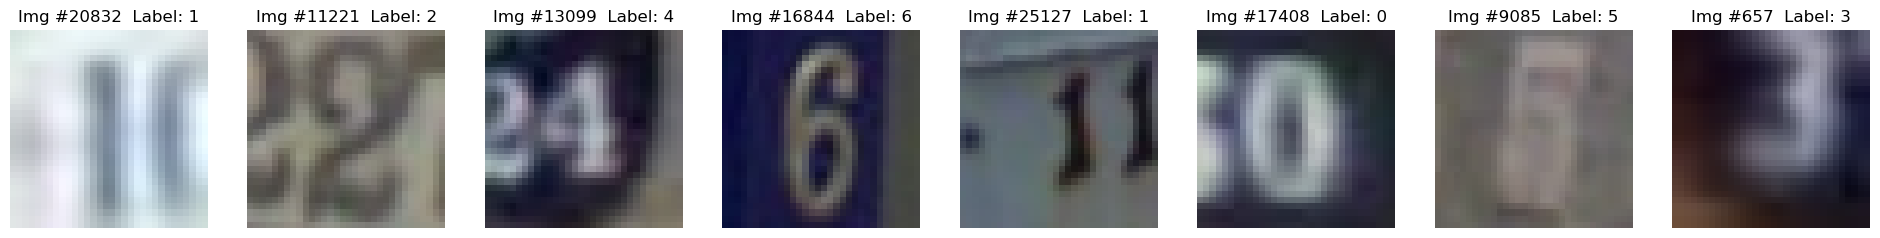

In [7]:
###--- Visualize Evaluation Images ---###

NUM_IMG = 8

fig, ax = plt.subplots(1,NUM_IMG)
fig.set_size_inches(3 * NUM_IMG, 3)

ids = np.random.randint(low=0, high=len(test_dataset), size=NUM_IMG)

for i, n in enumerate(ids):
    img = test_dataset[n][0].permute(1,2,0)
    label = test_dataset[n][1]
    ax[i].imshow(img)
    ax[i].set_title(f"Img #{n}  Label: {label}")
    ax[i].axis("off")

## Training





### Model Configuration

In [8]:
###--- Training Parameters ---###

CONFIG_PATH = None
# Load configuration from an existing run
LOAD_CONFIG = False

if LOAD_CONFIG:
    EXP_NAME_CONFIG = 'template'
    RUN_NAME_CONFIG = 'test_01'

    MODEL_CONFIG = experiments.load_cofig(EXP_NAME_CONFIG, RUN_NAME_CONFIG)
    

if CONFIG_PATH is not None:
    MODEL_CONFIG = yaml.load(CONFIG_PATH)

### Define Model from the config

In [9]:
# Load model
if MODEL_CONFIG['model'] == 'mlp':
    model = models.load_mlp_model(MODEL_CONFIG)

model = model.to(DEVICE)

# Load criterion for loss computation
criterion = src.initialize_loss(MODEL_CONFIG['loss'])

# Load optimizer
optimizer = src.initialize_optimizer(model, MODEL_CONFIG['optimizer'])



In [10]:
# Initialize logger to get training and evaluation results
logger = experiments.Logger(
                exp_name = EXPERIMENT_NAME,
                run_name = RUN_NAME,
                model_config = MODEL_CONFIG,
                anon_mode = not WRITE_LOGS, # Whether to write to logs outside of notebook
)

# Initialize logger to log the training
logger.init_training()

# Print logger configuration for debugging
logger._print_logger_config()

Run environement not completely specified. Logger running in anonymous mode --> No logging to disk.
Logger was initialized for training.
 <----Logger Configuration---->
  Log Gradients: False
  Log Data: True
  Checkpoint Frequency: 0
  Verbose: False
  Log Gradients: False
  Log Data: True
  Checkpoint Frequency: 2
  Anonymous Mode: True
  Disabled: False
  Verbose: False
  Current Logger State:
    Log ID: test_010000
    Training: True
    Evaluation: False
    Tuning: False
    Epoch: 0
    Iteration: 0

 --Model Configuration--
  run_name: test
  model: mlp
  num_epochs: 10
  num_iterations: 0
  dataset: {'name': 'svhn', 'train_size': 73257, 'val_size': 6000, 'test_size': 26032, 'train_shuffle': True, 'eval_shuffle': False, 'drop_last': True}
  batch_size: 64
  loss: {'type': 'CrossEntropy'}
  eval_batch_size: 32
  eval_frequency: 2
  pre_processing: {'flatten': True, 'flatten_only_img_sizes': True, 'rgb2gray': True, 'lbl_oneHot': True}
  layers: [{'type': 'linear', 'dimension': 5

### Train Model


In [11]:
# Train the model, all results are saved withing the logger and can be retrieved when needed.

# Initialize logger to log the training
logger.init_training()

src.train_model_01(
                model = model,
                train_dataset = train_loader,
                eval_dataset = test_loader,
                optimizer = optimizer,
                criterion = criterion,
                config = MODEL_CONFIG,
                logger = logger
)

# Finish logging of training automatically initializes logging of evaluation.
logger.finish()

src.run_evaluation(
                model = model,
                dataset = test_loader,
                logger = logger
)

# Finish logging of evaluation. All results we are interested in are saved withing the logger and can be retrieved when needed.
logger.finish()

Logger was initialized for training.
----Training for model test----

Hyperparameters:
   run_name: test
  model: mlp
  num_epochs: 10
  num_iterations: 0
  dataset: {'name': 'svhn', 'train_size': 73257, 'val_size': 6000, 'test_size': 26032, 'train_shuffle': True, 'eval_shuffle': False, 'drop_last': True}
  batch_size: 64
  loss: {'type': 'CrossEntropy'}
  eval_batch_size: 32
  eval_frequency: 2
  pre_processing: {'flatten': True, 'flatten_only_img_sizes': True, 'rgb2gray': True, 'lbl_oneHot': True}
  layers: [{'type': 'linear', 'dimension': 518, 'activation': 'relu'}, {'type': 'linear', 'dimension': 128, 'activation': 'relu'}, {'type': 'linear', 'dimension': 64, 'activation': 'relu'}, {'type': 'linear', 'dimension': 32, 'activation': 'relu'}, {'type': 'linear', 'dimension': 10, 'activation': 'softmax'}]
  input_dim: 1024
  output_dim: 10
  optimizer: {'type': 'Adam', 'learning_rate': 0.001, 'betas': [0.9, 0.99], 'eps': 1e-08}
  evaluation: {'metrics': ['accuracy'], 'classes': []}
  sa

KeyError: 'rgb2gray'